# 1. Import library

In [1]:
from torchvision.datasets.utils import download_url
import torch
import tarfile

In [2]:
from torch.utils.data import Dataset
import os
DATA_DIR = './data/oxford-iiit-pet/images'

In [3]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
torch.manual_seed(2022)

In [5]:
from torch.utils.data import random_split
val_pct = 0.1
from torch.utils.data import DataLoader
batch_size = 256

In [6]:
from torchvision.utils import make_grid

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [51]:
import torch
from tqdm.notebook import tqdm
import numpy as np

# 2. Load data

In [9]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [10]:
with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [11]:
files = os.listdir(DATA_DIR)
files[:5]

['japanese_chin_8.jpg',
 'Ragdoll_24.jpg',
 'leonberger_169.jpg',
 'shiba_inu_154.jpg',
 'american_pit_bull_terrier_138.jpg']

In [12]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [13]:
parse_breed(files[4])

'american pit bull terrier'

In [14]:
def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

# 3. Create custom pytorch dataset

In [15]:
import os

class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx

In [16]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size), 
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), 
                                           T.Normalize(*imagenet_stats)]))

In [17]:
len(dataset)

7390

In [18]:
len(dataset.classes)

37

# 3.1. Display some images

In [19]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: leonberger (5)


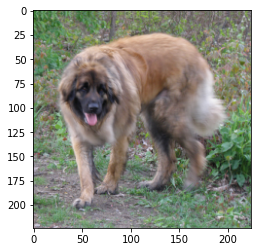

In [20]:
show_image(*dataset[2])

# 4. Split data to train and valid

In [21]:
val_size = int(val_pct * len(dataset))
train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [67]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


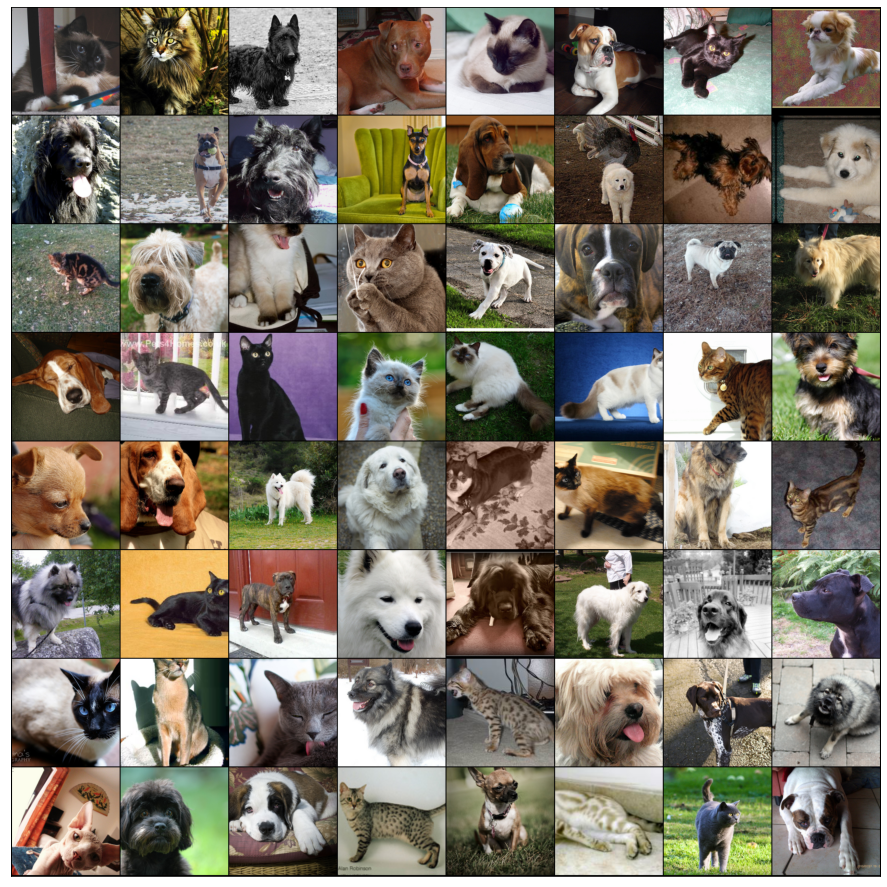

In [24]:
show_batch(train_dl)

# 5. Modifying a Pretrained Model (ResNet34)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, train_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'], result['train_acc']))

In [26]:
class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

# Get to device

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# 6. Train

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_acces = []
        for batch in tqdm(train_loader):
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_acces.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acces).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_acces = []
        lrs = []
        for batch in tqdm(train_loader):
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_acces.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acces).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
device = get_default_device()
device

device(type='cuda')

In [68]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# 7. Train with weight pretrain

In [31]:
model = PetsModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [37]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.02859134040772915, 'val_loss': 3.882643699645996}]

In [39]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00589, train_loss: 1.3333, val_loss: 232.4778, val_acc: 0.0230, train_acc: 0.6464


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00994, train_loss: 2.0574, val_loss: 4.4625, val_acc: 0.1320, train_acc: 0.4121


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00812, train_loss: 1.2700, val_loss: 2.4141, val_acc: 0.3847, train_acc: 0.5970


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00463, train_loss: 0.8461, val_loss: 1.5732, val_acc: 0.5764, train_acc: 0.7315


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00133, train_loss: 0.4980, val_loss: 0.6743, val_acc: 0.7798, train_acc: 0.8348


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00000, train_loss: 0.3038, val_loss: 0.5740, val_acc: 0.8076, train_acc: 0.9032
CPU times: user 2min 18s, sys: 1min 2s, total: 3min 21s
Wall time: 7min 33s


# 7.1. Plot train, valid

In [49]:
def plot_accuracies(history):
    val_acces = [x['val_acc'] for x in history]
    train_acces = [x.get('train_acc') for x in history]
    plt.plot(train_acces, '-bx')
    plt.plot(val_acces, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim([0,5]) # set y: 0<= y <=5
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

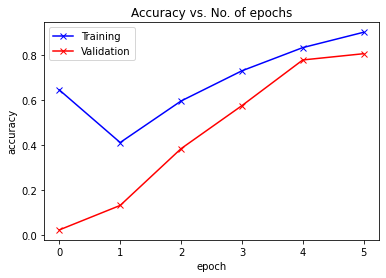

In [42]:
plot_accuracies(history[1:])

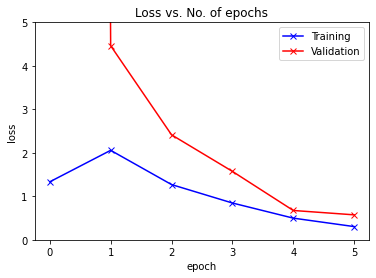

In [48]:
plot_losses(history[1:])

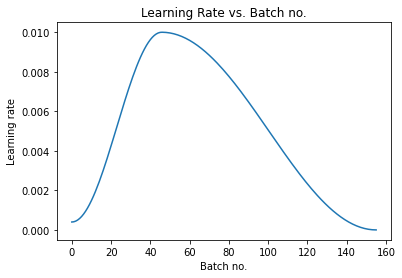

In [52]:
plot_lrs(history[1:])

# 7.2. Predict with individual image

In [57]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Bombay , Predicted: Bombay


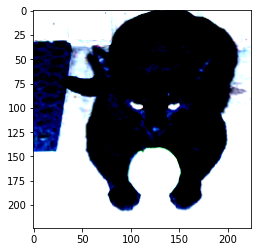

In [60]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 7.3. Analyst error

In [71]:
preds_all = []
actual_all = []
with torch.no_grad():
  for batch in valid_dl:
    torch.cuda.empty_cache()
    model.eval()
    images, labels = batch 
    outs = model(images)
    _, preds = torch.max(outs, dim=1)
    preds_all += preds.cpu().numpy().tolist()
    actual_all += labels.cpu().numpy().tolist()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [74]:
confu = confusion_matrix(actual_all, preds_all)
acc_label = [confu[i,i]/ sum(confu[i]) for i in range(len(confu))]
dict(zip(acc_label, dataset.classes))

{0.5714285714285714: 'Ragdoll',
 0.6: 'american pit bull terrier',
 0.6111111111111112: 'beagle',
 0.6129032258064516: 'wheaten terrier',
 0.6666666666666666: 'english cocker spaniel',
 0.6923076923076923: 'staffordshire bull terrier',
 0.7222222222222222: 'Egyptian Mau',
 0.7241379310344828: 'miniature pinscher',
 0.7391304347826086: 'British Shorthair',
 0.7619047619047619: 'Bengal',
 0.7647058823529411: 'keeshond',
 0.7692307692307693: 'leonberger',
 0.782608695652174: 'chihuahua',
 0.8095238095238095: 'english setter',
 0.8333333333333334: 'Maine Coon',
 0.8461538461538461: 'saint bernard',
 0.8571428571428571: 'Birman',
 0.8636363636363636: 'scottish terrier',
 0.8666666666666667: 'Persian',
 0.8823529411764706: 'Abyssinian',
 0.8928571428571429: 'yorkshire terrier',
 0.8947368421052632: 'newfoundland',
 0.9090909090909091: 'american bulldog',
 0.9166666666666666: 'pomeranian',
 0.9444444444444444: 'havanese',
 0.95: 'pug',
 0.9523809523809523: 'japanese chin',
 1.0: 'samoyed'}

In [76]:
wrong_index = [i for i in range(len(actual_all)) if actual_all[i] != preds_all[i] ]
len(wrong_index )

134

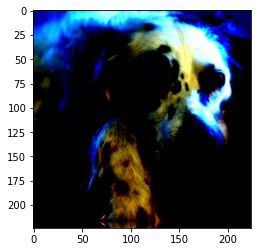

Label: english setter , Predicted: american bulldog


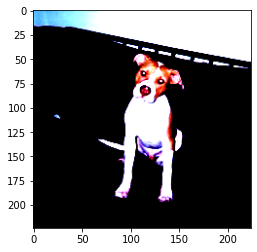

Label: american pit bull terrier , Predicted: american bulldog


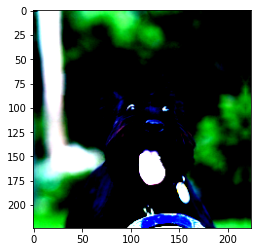

Label: scottish terrier , Predicted: newfoundland


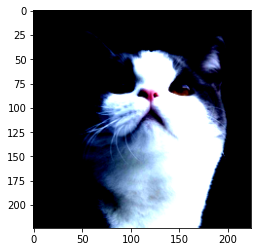

Label: British Shorthair , Predicted: Ragdoll


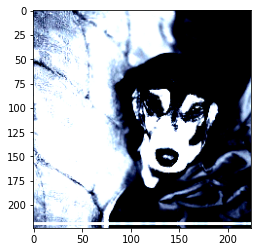

Label: beagle , Predicted: english setter


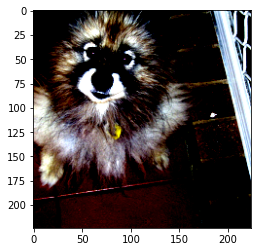

Label: keeshond , Predicted: pomeranian


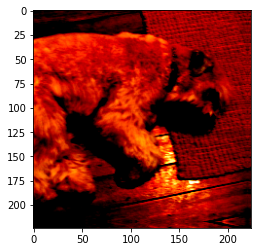

Label: wheaten terrier , Predicted: pomeranian


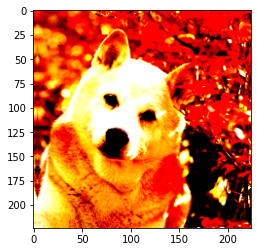

Label: shiba inu , Predicted: samoyed


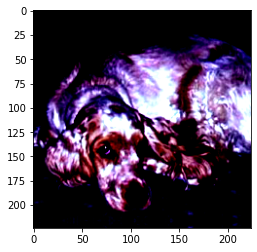

Label: english cocker spaniel , Predicted: english setter


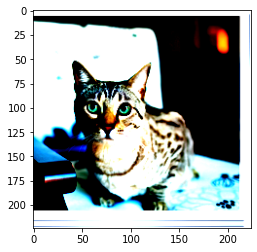

Label: Egyptian Mau , Predicted: Bengal


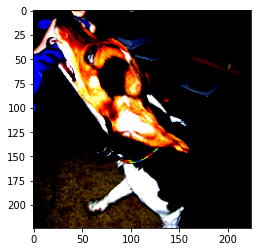

Label: beagle , Predicted: boxer


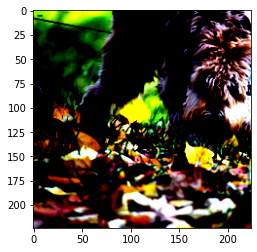

Label: wheaten terrier , Predicted: havanese


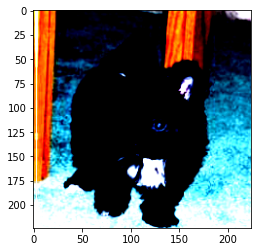

Label: yorkshire terrier , Predicted: scottish terrier


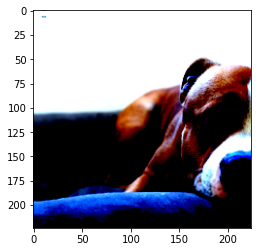

Label: staffordshire bull terrier , Predicted: basset hound


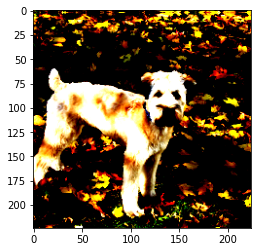

Label: wheaten terrier , Predicted: great pyrenees


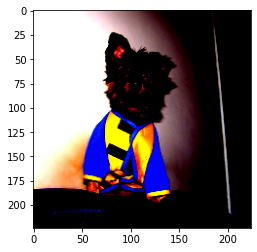

Label: yorkshire terrier , Predicted: miniature pinscher


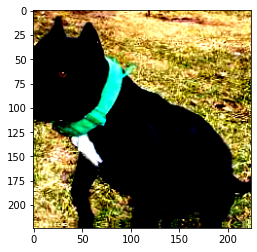

Label: american pit bull terrier , Predicted: staffordshire bull terrier


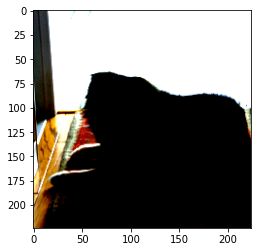

Label: leonberger , Predicted: leonberger


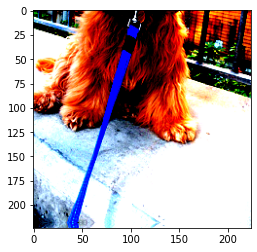

Label: english cocker spaniel , Predicted: english cocker spaniel


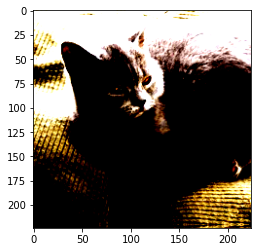

Label: British Shorthair , Predicted: Russian Blue


In [78]:
# display 10 random images predict error
for i in np.random.choice(wrong_index, 20, replace=False):
  img, label = valid_ds[i]
  plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
  plt.show()
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 8. Train from scraf

In [79]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [80]:
history2 = [evaluate(model2, valid_dl)]
history2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.028508169576525688, 'val_loss': 55.44216537475586}]

In [81]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00589, train_loss: 3.5710, val_loss: 159.8425, val_acc: 0.0288, train_acc: 0.0726


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00994, train_loss: 3.4657, val_loss: 49.1114, val_acc: 0.0368, train_acc: 0.0880


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00812, train_loss: 3.1837, val_loss: 3.7645, val_acc: 0.0816, train_acc: 0.1247


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00463, train_loss: 2.9344, val_loss: 3.3575, val_acc: 0.1217, train_acc: 0.1782


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00133, train_loss: 2.6971, val_loss: 2.9001, val_acc: 0.1798, train_acc: 0.2350


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00000, train_loss: 2.4737, val_loss: 2.6221, val_acc: 0.2417, train_acc: 0.2897
CPU times: user 2min 18s, sys: 1min 2s, total: 3min 21s
Wall time: 7min 28s


# 8.1. Plot train, valid

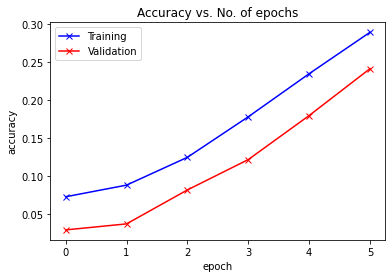

In [82]:
plot_accuracies(history2[1:])

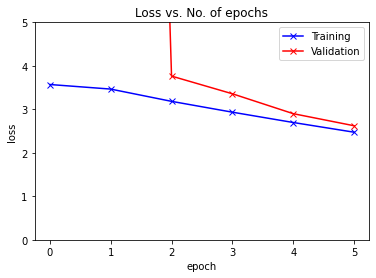

In [83]:
plot_losses(history2[1:])

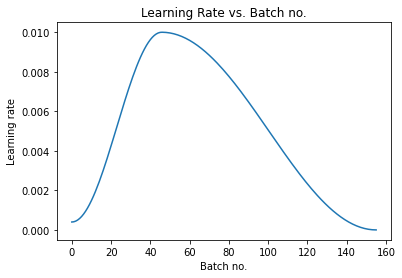

In [84]:
plot_lrs(history2[1:])